# Training

In [1]:
import os, datetime
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import batch_norm
from DataLoader import *
import sys
from matplotlib import pyplot as plt

In [2]:
# Dataset Parameters
batch_size = 200  # 256
load_size = 256
fine_size = 224
c = 3
data_mean = np.asarray([0.45834960097,0.44674252445,0.41352266842])
num_classes = 100

# Training Parameters
learning_rate = 0.001
dropout = 1 # Dropout, probability to keep units
training_iters = 0  # 50
step_display = 100
step_save = 500  # 25
model_path = '../models'
model = model_path + '/alexnet_model'
start_from = model_path

def batch_norm_layer(x, train_phase, scope_bn):
    return batch_norm(x, decay=0.9, center=True, scale=True,
    updates_collections=None,
    is_training=train_phase,
    reuse=None,
    trainable=True,
    scope=scope_bn)
    
def alexnet(x, keep_dropout, train_phase):
    weights = {
        'wc1': tf.Variable(tf.random_normal([11, 11, 3, 96], stddev=np.sqrt(2./(11*11*3)))),
        'wc2': tf.Variable(tf.random_normal([5, 5, 96, 256], stddev=np.sqrt(2./(5*5*96)))),
        'wc3': tf.Variable(tf.random_normal([3, 3, 256, 384], stddev=np.sqrt(2./(3*3*256)))),
        'wc4': tf.Variable(tf.random_normal([3, 3, 384, 256], stddev=np.sqrt(2./(3*3*384)))),
        'wc5': tf.Variable(tf.random_normal([3, 3, 256, 256], stddev=np.sqrt(2./(3*3*256)))),

        'wf6': tf.Variable(tf.random_normal([7*7*256, 4096], stddev=np.sqrt(2./(7*7*256)))),
        'wf7': tf.Variable(tf.random_normal([4096, 4096], stddev=np.sqrt(2./4096))),
        'wo': tf.Variable(tf.random_normal([4096, 100], stddev=np.sqrt(2./4096)))
    }

    biases = {
        'bo': tf.Variable(tf.ones(100))
    }

    # Conv + ReLU + Pool, 224->55->27
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 4, 4, 1], padding='SAME')
    conv1 = batch_norm_layer(conv1, train_phase, 'bn1')
    conv1 = tf.nn.relu(conv1, name='conv1')
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    # Conv + ReLU  + Pool, 27-> 13
    conv2 = tf.nn.conv2d(pool1, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = batch_norm_layer(conv2, train_phase, 'bn2')
    conv2 = tf.nn.relu(conv2, name='conv2')
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    # Conv + ReLU, 13-> 13
    conv3 = tf.nn.conv2d(pool2, weights['wc3'], strides=[1, 1, 1, 1], padding='SAME')
    conv3 = batch_norm_layer(conv3, train_phase, 'bn3')
    conv3 = tf.nn.relu(conv3, name='conv3')

    # Conv + ReLU, 13-> 13
    conv4 = tf.nn.conv2d(conv3, weights['wc4'], strides=[1, 1, 1, 1], padding='SAME')
    conv4 = batch_norm_layer(conv4, train_phase, 'bn4')
    conv4 = tf.nn.relu(conv4, name='conv4')

    # Conv + ReLU + Pool, 13->6
    conv5 = tf.nn.conv2d(conv4, weights['wc5'], strides=[1, 1, 1, 1], padding='SAME')
    conv5 = batch_norm_layer(conv5, train_phase, 'bn5')
    conv5 = tf.nn.relu(conv5, name='conv5')
    pool5 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool5')

    # FC + ReLU + Dropout
    fc6 = tf.reshape(pool5, [-1, weights['wf6'].get_shape().as_list()[0]])
    fc6 = tf.matmul(fc6, weights['wf6'])
    fc6 = batch_norm_layer(fc6, train_phase, 'bn6')
    fc6 = tf.nn.relu(fc6, name='fc6')
    fc6 = tf.nn.dropout(fc6, keep_dropout)
    
    # FC + ReLU + Dropout
    fc7 = tf.matmul(fc6, weights['wf7'])
    fc7 = batch_norm_layer(fc7, train_phase, 'bn7')
    fc7 = tf.nn.relu(fc7, name='fc7')
    fc7 = tf.nn.dropout(fc7, keep_dropout)

    # Output FC
    out = tf.add(tf.matmul(fc7, weights['wo']), biases['bo'])
    
    return {'conv1':conv1, 'pool1':pool1, 'conv2':conv2, 'pool2':pool2, 'conv3':conv3, 
            'conv4':conv4, 'conv5':conv5, 'pool5':pool5, 'fc6':fc6, 'fc7':fc7, 'out':out}

# tf Graph input
x = tf.placeholder(tf.float32, [None, fine_size, fine_size, c])
y = tf.placeholder(tf.int64, None)
keep_dropout = tf.placeholder(tf.float32)
train_phase = tf.placeholder(tf.bool)

# Construct model
global_step = tf.Variable(0, trainable=False, name='global_step')
tf.add_to_collection('global_step', global_step)
tensors = alexnet(x, keep_dropout, train_phase)
logits = tensors['out']

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Evaluate model
accuracy1 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, y, 1), tf.float32))
accuracy5 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, y, 5), tf.float32))

# define initialization
init = tf.global_variables_initializer()

# define saver
# jfon: need to be defined after declaring all variables
saver = tf.train.Saver(max_to_keep=2)

sess = tf.Session()

tf.global_variables_initializer().run(session=sess)
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

# Functions for retrieving, quantizing, and plotting activations

In [ ]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,],order='F'),keep_prob:1.0})
    return units
    
def quantizeInts(float_data):
    return np.around(float_data, decimals=0)

def quantizeThreshold(float_1d_arr, percentile_threshold):
    cutoff = np.percentile(float_1d_arr, percentile_threshold)
    low_values_ix = float_1d_arr < cutoff
    high_values_ix = float_1d_arr >= cutoff
    float_1d_arr[low_values_ix] = 0
    float_1d_arr[high_values_ix] = 1
    return float_1d_arr

def plotTestImage(image, out_filename=None):
    plt.figure(1, figsize=(3,3))
    plt.axis('off')
    plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")
    
    if out_filename is not None:
        fig = plt.gcf()
        print 'saving test image under %s' % out_filename
        fig.savefig(out_filename, bbox_inches='tight', format='PDF', transparent=False)


def plotNNFilter(units, out_filename_prefix=None):
    filters = units.shape[3]
    for i in range(filters):
        plt.figure(i, figsize=(3,3))   
        plt.axis('off')
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
        if out_filename_prefix is not None:
            filename = '%s-filter_%d.pdf' % (out_filename_prefix, i)
            print 'saving filter fig under %s' % filename
            fig = plt.gcf()
            fig.savefig(filename, bbox_inches='tight', format='PDF', transparent=False)

In [3]:
data_folder = '../externals/miniplaces_challenge/data'
# Construct dataloader
opt_data_train = {
    #'data_h5': 'miniplaces_256_train.h5',
    'data_root': os.path.join(data_folder, 'images'),   # MODIFY PATH ACCORDINGLY
    'data_list': os.path.join(data_folder, 'train.txt'), # MODIFY PATH ACCORDINGLY
    'load_size': load_size,
    'fine_size': fine_size,
    'data_mean': data_mean,
    'randomize': False
    }
opt_data_val = {
    #'data_h5': 'miniplaces_256_val.h5',
    'data_root': os.path.join(data_folder, 'images'),   # MODIFY PATH ACCORDINGLY
    'data_list': os.path.join(data_folder, 'val.txt'),   # MODIFY PATH ACCORDINGLY
    'load_size': load_size,
    'fine_size': fine_size,
    'data_mean': data_mean,
    'randomize': False
    }

opt_data_we = {
    #'data_h5': 'miniplaces_256_val.h5',
    'data_root': os.path.join(data_folder, 'images'),   # MODIFY PATH ACCORDINGLY
    'data_list': os.path.join(data_folder, 'we.txt'),   # MODIFY PATH ACCORDINGLY
    'load_size': load_size,
    'fine_size': fine_size,
    'data_mean': data_mean,
    'randomize': False
    }

loader_train = DataLoaderDisk(**opt_data_train)
loader_val = DataLoaderDisk(**opt_data_val)
loader_we = DataLoaderDisk(**opt_data_we)

('# Images found:', 100000)
('# Images found:', 10000)
('# Images found:', 2)


In [4]:
import math
loader = loader_val
select_percentage = .1
batch_size = min(100, loader.size())
filename_num = 1
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
feat_types = ['top10%', 'max', 'avg']

loader.reset()
num_batch = loader.size()//batch_size
act_files = {}
for ft in feat_types:
    act_files[ft] = {}
    for layer_name in layers:
        fname = 'val_{}_{}_activations.txt'.format(ft, layer_name)
        act_files[ft][layer_name] = open(fname, 'w')
with open ('val_predictions.txt', 'w') as preds:
    for batch_num in range(num_batch):
        print "starting batch from im {}".format(batch_num*batch_size+1)
        image_batch, _ = loader.next_batch(batch_size)
        conv1, conv2, conv3, conv4, conv5, logits_out = sess.run([tensors[layer] for layer in layers]+[tensors['out']],
                                                                 feed_dict={x:image_batch, keep_dropout:1.,
                                                                            train_phase:False})
        layer_outs = {'conv1':conv1, 'conv2':conv2, 'conv3':conv3, 'conv4':conv4, 'conv5':conv5}

        
        for batch_idx in range(batch_size):
            filename = 'val/{:08d}.jpg'.format(batch_num*batch_size+batch_idx+1)
            # max 10% avg summary
            for layer_name in layers:
                tensor = layer_outs[layer_name]
                num_pixels_to_average = max(1, int(.1*tensor.shape[1]*tensor.shape[2]))
                num_neurons = tensor.shape[3]
                if layer_name == layers[0]:
                    
                    preds_index = range(0, 100)
                    preds_index.sort(key=lambda index: logits_out[batch_idx][index], reverse=True)
                    preds.write('{} {}\n'.format(filename, ' '.join([str(idx) for idx in preds_index])))
                feature_10p = []
                feature_max = []
                feature_avg = []
                for neuron_idx in range(num_neurons):
                    flattened = tensor[batch_idx, :, :, neuron_idx].flatten()
                    feature_max.append(np.max(flattened))
                    feature_avg.append(np.mean(flattened))
                    top_activated = np.sort(flattened)[-num_pixels_to_average:]
                    feature_10p.append(np.mean(top_activated))
                act_files['top10%'][layer_name].write('{} {}\n'.format(filename, ' '.join([str(num) for num in feature_10p])))
                act_files['max'][layer_name].write('{} {}\n'.format(filename, ' '.join([str(num) for num in feature_max])))
                act_files['avg'][layer_name].write('{} {}\n'.format(filename, ' '.join([str(num) for num in feature_avg])))
                    
                

                
for t in act_files.keys():
    for f in act_files[t].keys():
        act_files[t][f].close()
                
    #sess.run(tensors['out'], feed_dict={x:image_batch, keep_dropout:1., train_phase:False})


starting batch from im 1
starting batch from im 101
starting batch from im 201
starting batch from im 301
starting batch from im 401
starting batch from im 501
starting batch from im 601
starting batch from im 701
starting batch from im 801
starting batch from im 901
starting batch from im 1001
starting batch from im 1101
starting batch from im 1201
starting batch from im 1301
starting batch from im 1401
starting batch from im 1501
starting batch from im 1601
starting batch from im 1701
starting batch from im 1801
starting batch from im 1901
starting batch from im 2001
starting batch from im 2101
starting batch from im 2201
starting batch from im 2301
starting batch from im 2401
starting batch from im 2501
starting batch from im 2601
starting batch from im 2701
starting batch from im 2801
starting batch from im 2901
starting batch from im 3001
starting batch from im 3101
starting batch from im 3201
starting batch from im 3301
starting batch from im 3401
starting batch from im 3501
star

starting batch from im 1


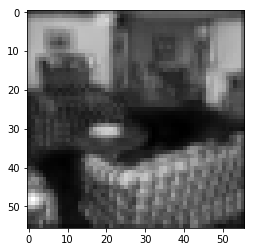

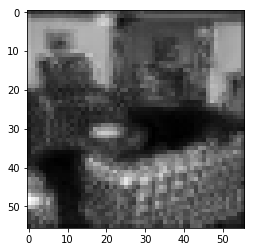

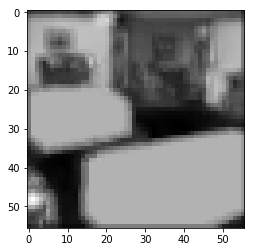

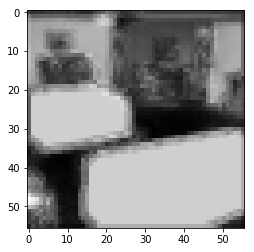

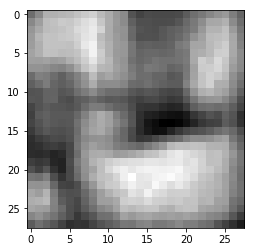

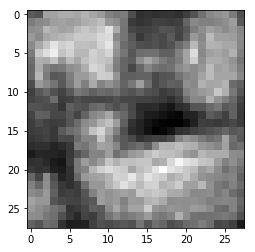

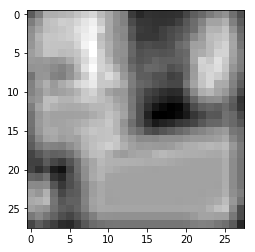

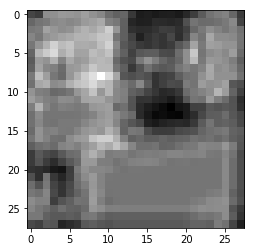

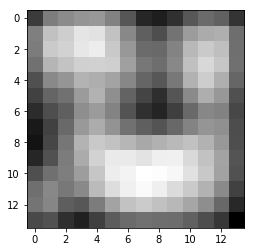

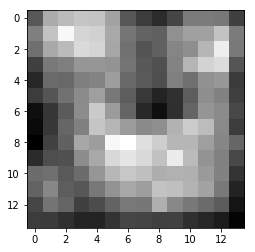

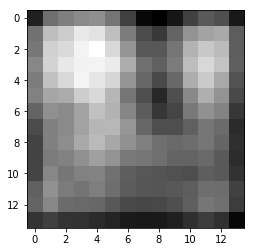

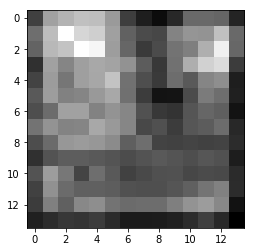

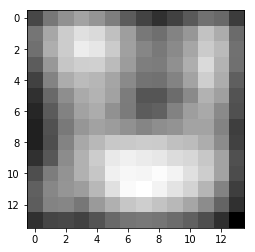

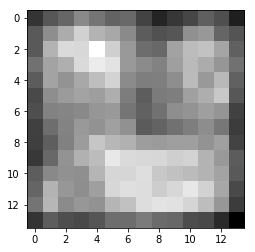

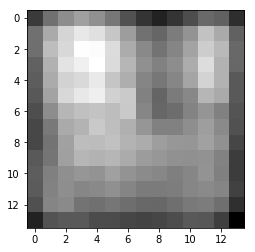

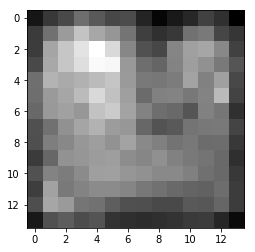

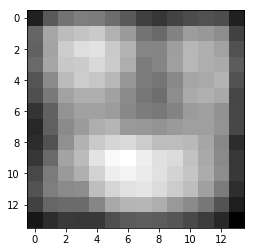

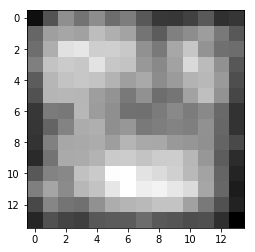

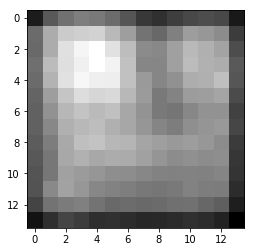

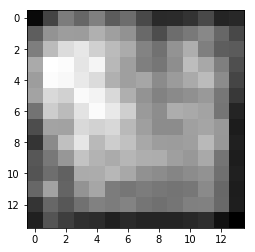

In [7]:
import math
loader = loader_we
select_percentage = .1
batch_size = min(100, loader.size())
filename_num = 1
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
feat_types = ['top10%', 'max', 'avg']

loader.reset()
num_batch = loader.size()//batch_size
act_files = {}

for batch_num in range(num_batch):
    print "starting batch from im {}".format(batch_num*batch_size+1)
    image_batch, _ = loader.next_batch(batch_size)
    conv1, conv2, conv3, conv4, conv5, logits_out = sess.run([tensors[layer] for layer in layers]+[tensors['out']],
                                                             feed_dict={x:image_batch, keep_dropout:1.,
                                                                        train_phase:False})
    layer_outs = {'conv1':conv1, 'conv2':conv2, 'conv3':conv3, 'conv4':conv4, 'conv5':conv5}
    
    for layer_name in layers:
#         print layer_outs[layer_name].shape
#         continue
        for batch_idx in range(batch_size):
            tensor = layer_outs[layer_name][batch_idx]
            num_pixels_to_average = max(1, int(.1*tensor.shape[2]))
            avg_act = np.mean(tensor, axis=2)
            plt.imshow(avg_act, cmap='gray')
            plt.show()
            max_act = np.max(tensor, axis=2)
            plt.imshow(max_act, cmap='gray')
            plt.show()
            
            
            
            
                                        

for t in act_files.keys():
    for f in act_files[t].keys():
        act_files[t][f].close()
                
    #sess.run(tensors['out'], feed_dict={x:image_batch, keep_dropout:1., train_phase:False})
